In [6]:
!pip install torch
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [96]:
# Load helpers and custom dataset class
from __init__ import PricingWizardDataset, base_regression_pipeline, regression_accuracy, threshold_accuracy

# Data manipulation 
import pandas as pd
import numpy as np
import time
import math

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

In [26]:
# Load Data
data = PricingWizardDataset()

Dataset Loaded: post_preprocessing_without_dummies
	Number of Rows: 283055
	Number of Columns: 22
	Outlier Removal: True
	Train Size: 0.8
	Test Size: 0.2
	Random State: 42


In [27]:
# Apply data preparation
print('Applying data preparation...')
data.apply_function(base_regression_pipeline)
print('Done.')

Applying data preparation...
Done.


In [28]:
# Split data
data.stratify_train_test_split(y_column='log_listing_price',
                               val_size=0,
                               return_splits=False)

Dependent variable distribution is equal across all subsets


## Linear SVR

In [38]:
# Defines a set of values to explore during the hyperparameter tuning process
linear_param_dist = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5, 1.0],
}

linear_svr = LinearSVR(dual="auto")
linear_svr

In [39]:
scaler = StandardScaler()

X_val = data.X
X_train = scaler.fit_transform(data.X_train.values)
X_test = scaler.fit_transform(data.X_test.values)
y_train = data.y_train
y_test = data.y_test

random_search = RandomizedSearchCV(
    linear_svr,
    param_distributions=linear_param_dist,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=3
)
random_search.fit(X_train, y_train)

# Get the best hyperparameters from Random Search
best_params_random: list = random_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increas

In [81]:
# Use the best hyperparameters from Random Search as initial values for Grid Search
grid_search_params = {
    key: [value] for key, value in best_params_random.items()
}

grid_search = GridSearchCV(
    linear_svr,
    param_grid=grid_search_params,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from Grid Search
best_params_grid: list = grid_search.best_params_

# Train the final model with the best hyperparameters from Grid Search
final_linear_model = grid_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [94]:
# Evaluate the model using cross-validation and calculates the mean
cv_scores: list = cross_val_score(final_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
mse_mean_cv_linear: float = -np.mean(cv_scores)

# Train the final model on the entire training set, measuring the training time in seconds
start_time = time.time()
final_model.fit(X_train, y_train)
end_time = time.time()

# Calculate training time
training_time_linear = end_time - start_time

# Evaluate the final model on the test set
y_pred_test = final_model.predict(X_test)

regression_accuracy(y_pred_test, y_test)
print("Cross-validation Score:", mse_mean_cv_linear)
print("Training Time:", training_time_linear)

R2 Score: 0.5453659715616684
MSE: 0.43802997609070926
MAE 0.5129794158820556
RMSE 0.6618383307807952
Cross-validation Score: 0.44087896537209625
Training Time: 0.660560131072998


In [83]:
# Calculate permutation importances for the regressor to have a similar metric between the models
feature_importances_values = permutation_importance(final_linear_model, X_test, y_test, n_repeats=10, random_state=42).importances_mean
feature_importance = pd.DataFrame({'Feature': X_val.columns, 'Importance': feature_importances_values})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
1,brand_name,0.637279
3,subsubsubcategory_name,0.129699
2,condition_name,0.057985
0,classified_id,0.000476


In [84]:
# Feature importance based on regressor coefficients
model_coef = final_linear_model.coef_
feature_importance = pd.DataFrame({'Feature': X_val.columns, 'Coef': model_coef})
feature_importance.sort_values(by='Coef', ascending=False)

,Feature,Coef
1,brand_name,0.560260
3,subsubsubcategory_name,0.256093
2,condition_name,0.170440
0,classified_id,0.016589


## SVR RBF

In [97]:
# Define regressor
rbf_svr = SVR(kernel="rbf")
rbf_svr

SVR()

In [ ]:
# Evaluate the model using cross-validation and calculates the mean
cv_scores: list = cross_val_score(rbf_svr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
mse_mean_cv_rbf: float = -np.mean(cv_scores)

# Train the final model on the entire training set, measuring the training time in seconds
start_time = time.time()
rbf_svr.fit(X_train, y_train)
end_time = time.time()

# Calculate training time
training_time_rbf = end_time - start_time

# Evaluate the final model on the test set
y_pred_test = rbf_svr.predict(X_test)

regression_accuracy(y_pred_test, y_test)
print("Cross-validation Score:", mse_mean_cv_rbf)
print("Training Time:", training_time_rbf)

In [ ]:
# Calculate permutation importances for the regressor to have a similar metric between the models
feature_importances_values = permutation_importance(rbf_svr, X_test, y_test, n_repeats=10, random_state=42).importances_mean
feature_importance = pd.DataFrame({'Feature': X_val.columns, 'Importance': feature_importances_values})
feature_importance.sort_values(by='Importance', ascending=False)

In [ ]:
# Feature importance based on regressor coefficients
model_coef = rbf_svr.coef_
feature_importance = pd.DataFrame({'Feature': X_val.columns, 'Coef': model_coef})
feature_importance.sort_values(by='Coef', ascending=False)

## Visualizations

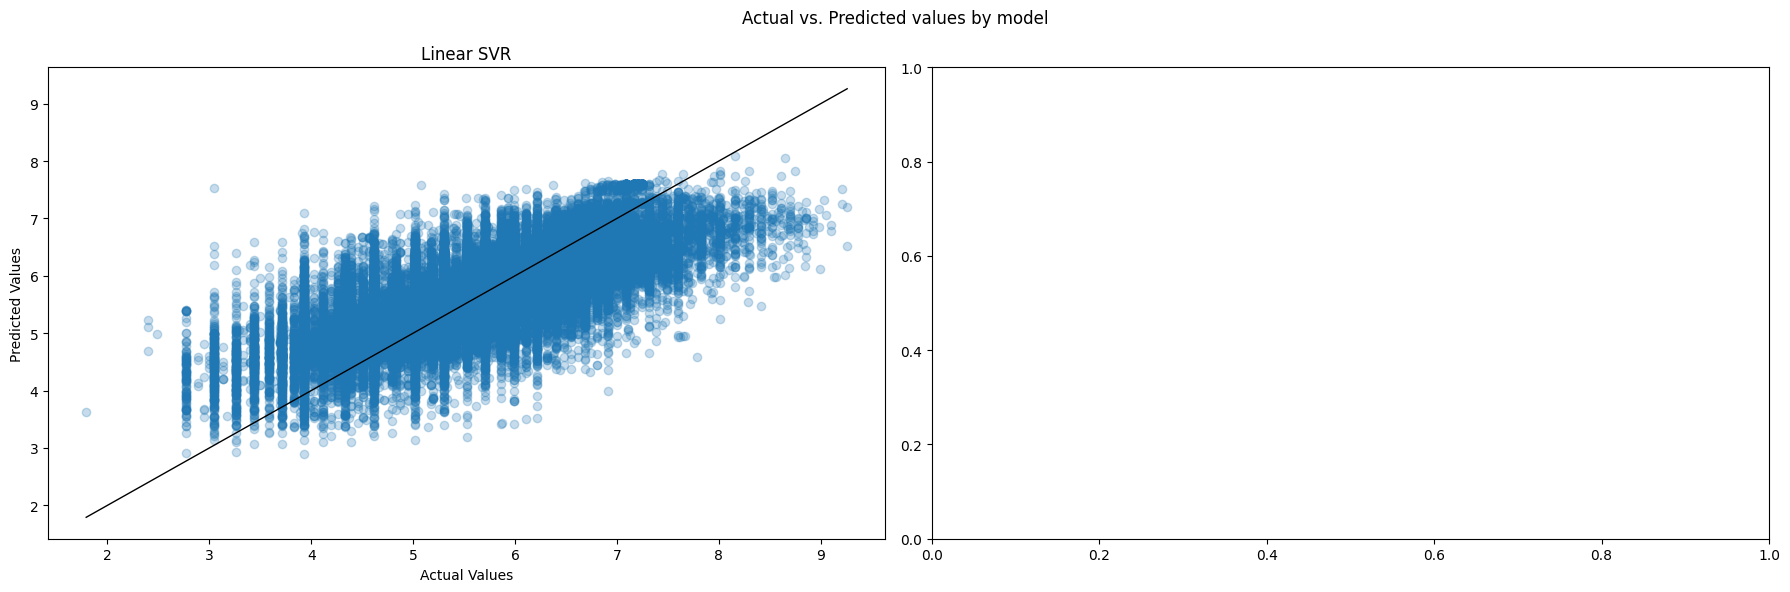

In [87]:
# actual vs predicted
models = [final_linear_model]
labels= ["Linear SVR"]

num_models = len(models)
num_cols = 2
num_rows = math.ceil(num_models / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 6*num_rows), tight_layout=True)
axs = axs.flatten()

for i, model in enumerate(models):
    axs[i].scatter(y_test, y_pred_test, alpha=0.25)
    axs[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k', lw=1)
    axs[i].set_title(labels[i])
    axs[i].set_xlabel('Actual Values')
    axs[i].set_ylabel('Predicted Values')

plt.suptitle("Actual vs. Predicted values by model")

plt.show(fig)

TypeError: 'Axes' object is not subscriptable

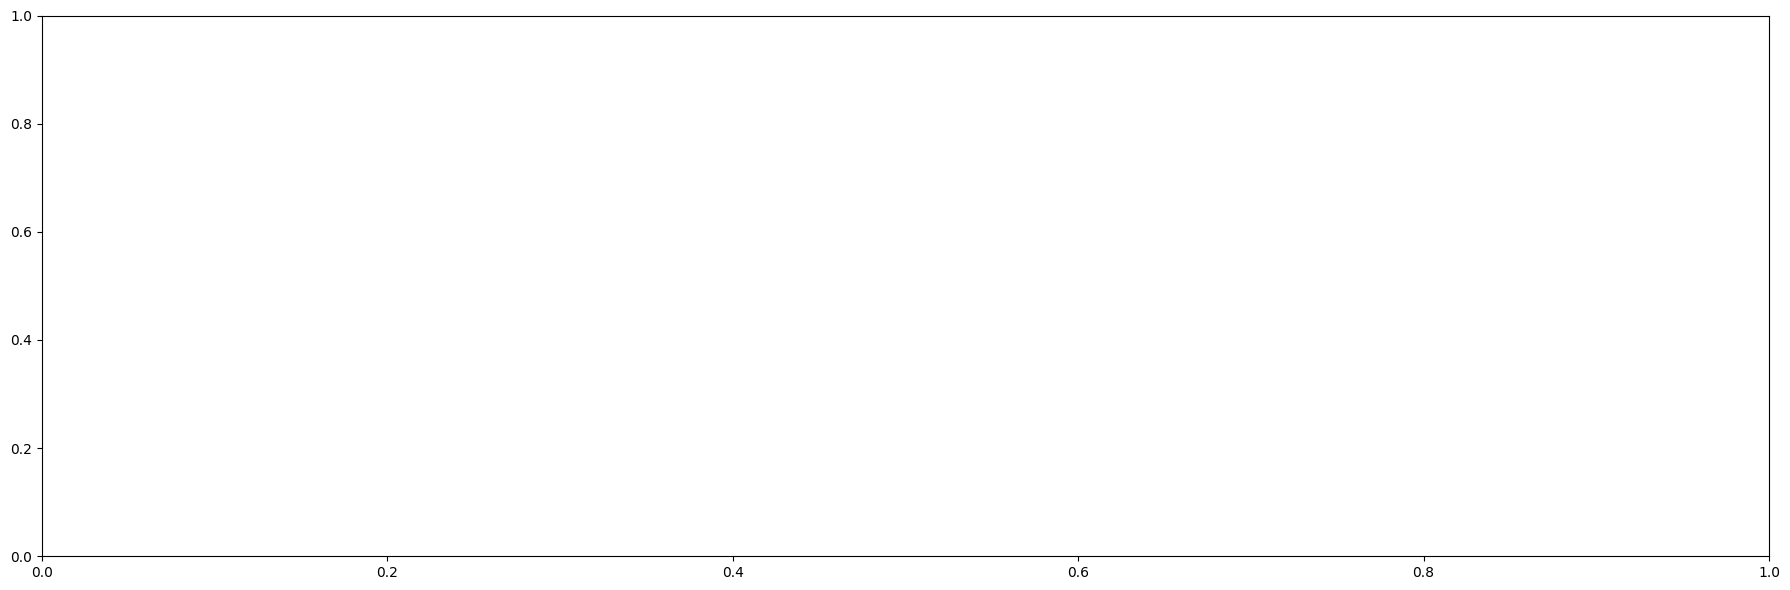

In [90]:
# residuals
models = [final_linear_model]
labels= ["Linear SVR"]

num_models = len(models)
num_cols = 2
num_rows = math.ceil(num_models / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 6*num_rows), tight_layout=True)

for i, model in enumerate(models):
    # Calculate residuals
    prediction_error = y_test[i] - y_pred_test

    # Extract the subplot for the current model
    row = i // num_cols
    col = i % num_cols

    # Plot the scatter plot on the specific subplot
    axs[row, col].scatter(y_pred_test, prediction_error, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    axs[row, col].set_title(labels[i])
    axs[row, col].set_xlabel('Predicted Values')
    axs[row, col].set_ylabel('Prediction Errors')

plt.suptitle("Residual values by model")

plt.show(fig)

In [ ]:
# model evaluation
regressor_names = [result.label for results in results.values() for result in results]

mse_mean_cv_values = [result.mse_mean_cv for results in results.values() for result in results]
mse_test_values = [result.mse_test for results in results.values() for result in results]

bar_width = 0.35
index = range(len(regressor_names))

fig, ax = plt.subplots(tight_layout=True)
bar1 = ax.bar(index, mse_mean_cv_values, bar_width, label='MSE Mean CV')
bar2 = ax.bar([i + bar_width for i in index], mse_test_values, bar_width, label='MSE Test')

ax.set_xlabel('Regressor')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('MSE Mean CV and MSE Test for Each Regressor')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(regressor_names)
ax.legend()

plt.show(fig)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

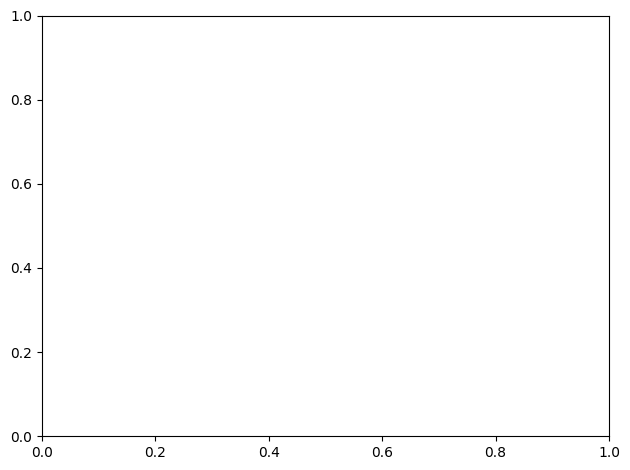

In [91]:
# Calculate mean for each row (feature)
df['average'] = df.mean(axis=1)

# Add a new column for the rank of the mean values: (ascending=False) due to negative values
df['rank'] = df['average'].rank(ascending=False)

fig, ax = plt.subplots(tight_layout=True)

# Bar plot for average feature importances
sns.barplot(x=feature_importances.index, y=feature_importances['average'], hue=feature_importances.index, legend=False)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax.set_title('Average Feature Importances')
ax.set_xlabel('Features')
ax.set_ylabel('Average Importance')
ax.tick_params(axis='x', labelsize=8)

plt.show(fig)

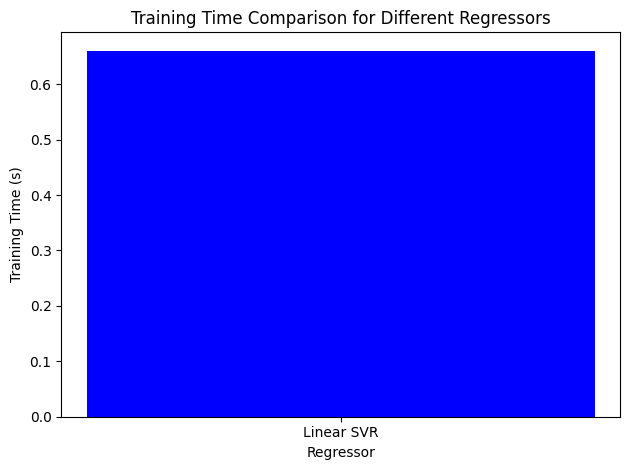

In [95]:
regressor_names = ["Linear SVR"]
training_times = [training_time_linear]

fig, ax = plt.subplots(tight_layout=True)
ax.bar(regressor_names, training_times, color='blue')
ax.set_xlabel('Regressor')
ax.set_ylabel('Training Time (s)')
ax.set_title('Training Time Comparison for Different Regressors')

plt.show(fig)